In [2]:
# instantiate pretrained VGG16 imagenet model
from tensorflow.keras.applications import VGG16
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150, 150, 3))

Metal device set to: Apple M1

systemMemory: 8.00 GB
maxCacheSize: 2.67 GB



2022-08-23 16:17:19.183529: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-23 16:17:19.183850: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


58892288/58889256 [==============================] - 246s 4us/step


In [9]:
# save VGG16 model output for feature extraction without data augmentation
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

base_dir = os.path.join(os.getcwd(), 'cats_and_dogs_small')

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = ImageDataGenerator(rescale=1/255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # shape of VGG16 output
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(directory,
                                            target_size=(150, 150),
                                            batch_size=batch_size,
                                            class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i+1) * batch_size] = features_batch
        labels[i * batch_size : (i+1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            break
    features = np.reshape(features, (sample_count, 4 * 4 * 512)) # flatten features
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [19]:
# train a new dense network on extracted features
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_dim=4 * 4 * 512))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit(train_features,
                    train_labels,
                    epochs=80,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))


Epoch 1/80
  6/100 [>.............................] - ETA: 0s - loss: 0.6878 - acc: 0.6083 

2022-08-23 20:12:54.263354: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 12ms/step - loss: 0.5761 - acc: 0.6970 - val_loss: 0.4639 - val_acc: 0.8120
Epoch 2/80
  7/100 [=>............................] - ETA: 0s - loss: 0.4465 - acc: 0.8357

2022-08-23 20:12:55.430312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 1s 10ms/step - loss: 0.4123 - acc: 0.8270 - val_loss: 0.3715 - val_acc: 0.8570
Epoch 3/80
100/100 [==============================] - 1s 10ms/step - loss: 0.3408 - acc: 0.8650 - val_loss: 0.3284 - val_acc: 0.8800
Epoch 4/80
100/100 [==============================] - 1s 9ms/step - loss: 0.2981 - acc: 0.8815 - val_loss: 0.3210 - val_acc: 0.8560
Epoch 5/80
100/100 [==============================] - 1s 10ms/step - loss: 0.2659 - acc: 0.9025 - val_loss: 0.2926 - val_acc: 0.8770
Epoch 6/80
100/100 [==============================] - 1s 9ms/step - loss: 0.2429 - acc: 0.9100 - val_loss: 0.2729 - val_acc: 0.8950
Epoch 7/80
100/100 [==============================] - 1s 10ms/step - loss: 0.2295 - acc: 0.9145 - val_loss: 0.2655 - val_acc: 0.8990
Epoch 8/80
100/100 [==============================] - 1s 9ms/step - loss: 0.2167 - acc: 0.9200 - val_loss: 0.2569 - val_acc: 0.8990
Epoch 9/80
100/100 [==============================] - 1s 9ms/step - loss: 0.1985 - 

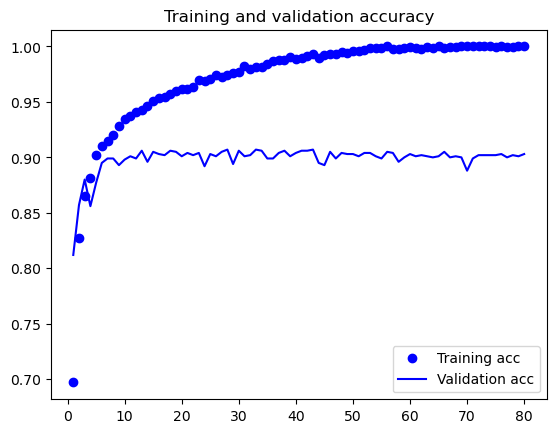

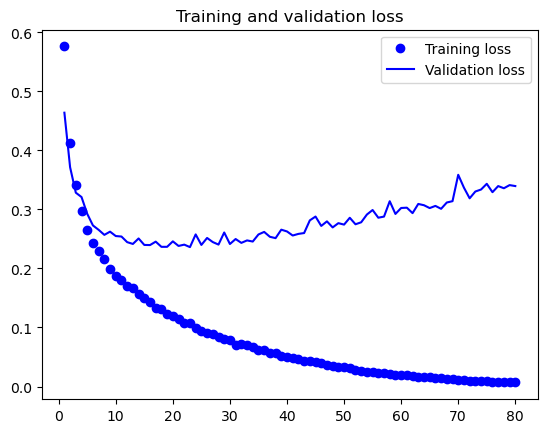

In [20]:
# plot train / validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
# create train / validation / test data generators for
# feature extraction with data augmentation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1/255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1/255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')


Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [28]:
# build and train model with frozen convolutional base
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

conv_base.trainable = False # freeze convolutional base before compilation

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=2e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=30,
                    validation_data=validation_generator,
                    validation_steps = 50)

Epoch 1/30


2022-08-23 22:00:24.788471: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.6071 - acc: 0.6750

2022-08-23 22:00:43.267058: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 28s 271ms/step - loss: 0.6071 - acc: 0.6750 - val_loss: 0.4869 - val_acc: 0.7750
Epoch 2/30
100/100 [==============================] - 27s 267ms/step - loss: 0.4891 - acc: 0.7725 - val_loss: 0.3747 - val_acc: 0.8630
Epoch 3/30
100/100 [==============================] - 27s 265ms/step - loss: 0.4348 - acc: 0.8170 - val_loss: 0.3355 - val_acc: 0.8710
Epoch 4/30
100/100 [==============================] - 26s 264ms/step - loss: 0.4073 - acc: 0.8135 - val_loss: 0.3095 - val_acc: 0.8770
Epoch 5/30
100/100 [==============================] - 27s 270ms/step - loss: 0.3785 - acc: 0.8415 - val_loss: 0.2992 - val_acc: 0.8840
Epoch 6/30
100/100 [==============================] - 29s 292ms/step - loss: 0.3652 - acc: 0.8450 - val_loss: 0.2847 - val_acc: 0.8780
Epoch 7/30
100/100 [==============================] - 31s 305ms/step - loss: 0.3563 - acc: 0.8475 - val_loss: 0.2738 - val_acc: 0.8870
Epoch 8/30
100/100 [==============================] - 31s 311ms/st

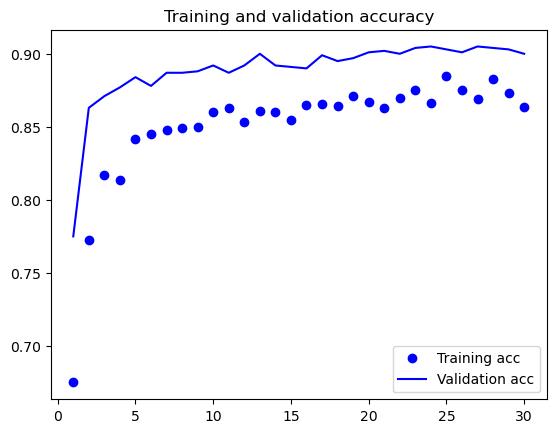

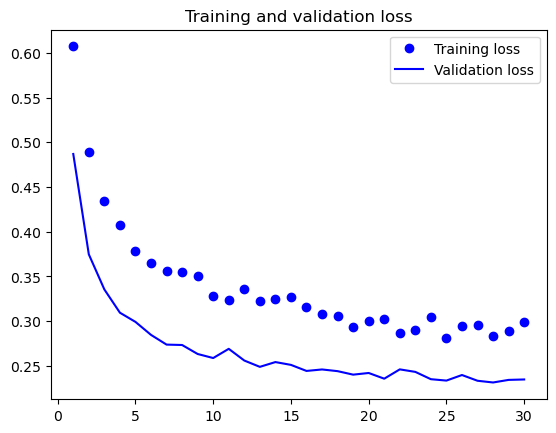

In [29]:
# plot train / validation accuracy and loss
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
# fine tune the last block of the convolutional base
# (AFTER training the dense network on top)
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1': # freeze layers before this
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(learning_rate=1e-5),
              metrics=['acc'])

history = model.fit(train_generator,
                    steps_per_epoch=100,
                    epochs=100,
                    validation_data=validation_generator,
                    validation_steps = 50)

model.save('cats_and_dogs_small_3.h5')

Epoch 1/100


2022-08-23 23:15:10.886335: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - ETA: 0s - loss: 0.2988 - acc: 0.8700

2022-08-23 23:15:33.355118: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


100/100 [==============================] - 32s 305ms/step - loss: 0.2988 - acc: 0.8700 - val_loss: 0.2231 - val_acc: 0.9080
Epoch 2/100
100/100 [==============================] - 30s 303ms/step - loss: 0.2602 - acc: 0.8915 - val_loss: 0.2074 - val_acc: 0.9150
Epoch 3/100
100/100 [==============================] - 31s 308ms/step - loss: 0.2450 - acc: 0.9015 - val_loss: 0.1986 - val_acc: 0.9190
Epoch 4/100
100/100 [==============================] - 31s 311ms/step - loss: 0.2342 - acc: 0.9075 - val_loss: 0.2009 - val_acc: 0.9190
Epoch 5/100
100/100 [==============================] - 32s 322ms/step - loss: 0.2134 - acc: 0.9075 - val_loss: 0.1908 - val_acc: 0.9280
Epoch 6/100
100/100 [==============================] - 33s 327ms/step - loss: 0.1969 - acc: 0.9145 - val_loss: 0.2552 - val_acc: 0.9070
Epoch 7/100
100/100 [==============================] - 33s 334ms/step - loss: 0.1944 - acc: 0.9170 - val_loss: 0.1778 - val_acc: 0.9310
Epoch 8/100
100/100 [==============================] - 35s 3

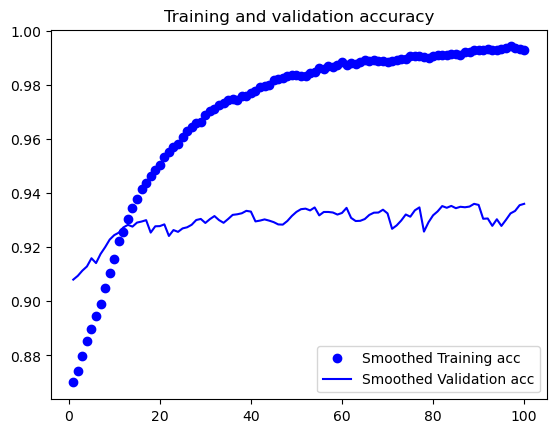

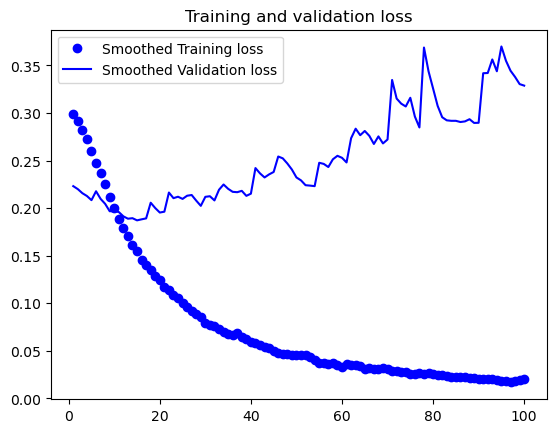

In [36]:
# plot smoothed train / validation accuracy and loss
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, smooth_curve(acc), 'bo', label='Smoothed Training acc')
plt.plot(epochs, smooth_curve(val_acc), 'b', label='Smoothed Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss), 'bo', label='Smoothed Training loss')
plt.plot(epochs, smooth_curve(val_loss), 'b', label='Smoothed Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
# evaluate the final model on test data
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_datagen = ImageDataGenerator(rescale=1/255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=20,
    class_mode='binary')

test_loss, test_acc = model.evaluate(test_generator, steps=50)

Found 1000 images belonging to 2 classes.
50/50 [==============================] - 9s 180ms/step - loss: 0.3798 - acc: 0.9330
